In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_utils import *
from PointMass_model import DifferentialActionModelPointMass

In [2]:
nx = 4
nu = 2
T = 50
start_point = np.array([5, 5, 0, 0])
target_low = np.array([10, 0, 0, 0])
target_high = np.array([10, 10, 0, 0])
obs0 = Obstacle(10, 8, 2, 1, 'Obs0')
obs1 = Obstacle(10, 8, 1, 2, 'Obs1')
obs2 = Obstacle(8, 10, 1, 2, 'Obs2')
obs3 = Obstacle(8, 8, 1, 2, 'Obs3')
obs_set = [obs1, obs2, obs3]
# obs_set = [obs0]
translation_cost = XReg(nx, target_high, 'trans_high')
xreg = XReg(nx, start_point, 'XReg')
ureg = UReg(nu, None, 'UReg')

cost_set = Costs()
cost_set.add_cost(translation_cost)
cost_set.add_cost(xreg)
cost_set.add_cost(ureg)
# cost_set.add_cost(obs0)
cost_set.add_cost(obs1)
cost_set.add_cost(obs2)
cost_set.add_cost(obs3)

nr = cost_set.nr

In [3]:
# Desired Running and Terminal Model
w_run = np.array([10, 1., 1., 1000, 1000, 1000])
w_term = np.array([2000, 1., 1., 1000, 1000, 1000])
# w_des = np.hstack([w_run, w_term])
w_des = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_des = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_des[:nr]; w_term = w_des[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 500)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.53125e+01  2.53125e+01  1.45970e+01  1.0000  0.00000e+00  4.98986e+00
   2  3.36626e+00  3.36626e+00  4.31861e-01  1.0000  4.44089e-14  3.68782e-01
   3  3.05261e+00  3.05261e+00  3.14947e-01  1.0000  3.92355e-10  1.93348e-01
   4  2.91456e+00  2.91456e+00  2.21626e-01  1.0000  3.52844e-10  1.19044e-01
   5  2.84870e+00  2.84870e+00  1.71164e-01  1.0000  3.28337e-10  7.46740e-02
   6  2.80966e+00  2.80966e+00  1.39565e-01  1.0000  2.63293e-10  4.88692e-02
   7  2.78302e+00  2.78302e+00  1.16167e-01  1.0000  2.94038e-10  3.31063e-02
   8  2.76278e+00  2.76278e+00  1.35873e-01  1.0000  1.89872e-10  5.96056e-02
   9  2.74173e+00  2.74173e+00  1.02702e-01  1.0000  2.11002e-10  2.38436e-02
  10  2.72711e+00  2.72711e+00  8.96921e-02  1.0000  1.87359e-10  2.07664e-02
iter     merit         cost         grad      step    ||gaps||        KKT
  11  2.71538e+00  2.71538e+00  5.94133e-01  1.0000  1.74446e-10  6.6992

In [4]:
# HTML(animatePointMass(xs_optimal, obs_set, target_high).to_jshtml())

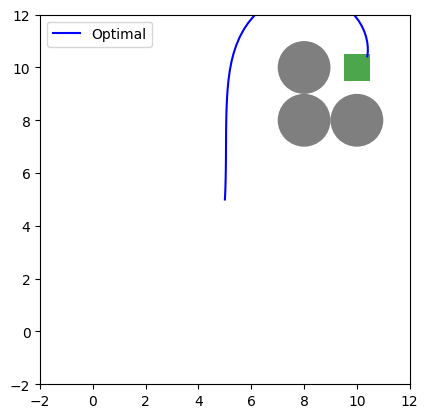

In [5]:
plot_1_traj(xs_optimal, obs_set, target_high, label='Optimal', linemap = 'b')

In [6]:
# Bad Running and Terminal Model
w_run = np.array([10, 1., 1., 0., 0., 0.])
w_term = np.array([1000, 1., 1., 0., 0., 0.])
# w_bad = np.hstack([w_run, w_term])
w_bad = (np.hstack([w_run, w_term])/(np.max(np.hstack([w_run, w_term])))).copy()
# w_bad = (np.hstack([w_run, w_term])/(np.linalg.norm(np.hstack([w_run, w_term])))).copy()
w_run = w_bad[:nr]; w_term = w_bad[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 500)
xs_non_optimal = np.stack(sqp_non_opt.xs.tolist().copy())
us_non_optimal = np.stack(sqp_non_opt.us.tolist().copy())
print(done)


iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.56250e+01  2.56250e+01  1.45677e+01  1.0000  0.00000e+00  4.97991e+00
True
 END  3.93930e-01  3.93930e-01  5.39967e-05   ----   4.52971e-14  2.19792e-07


In [7]:
# HTML(animatePointMass(xs_non_optimal, obs_set, target_high).to_jshtml())

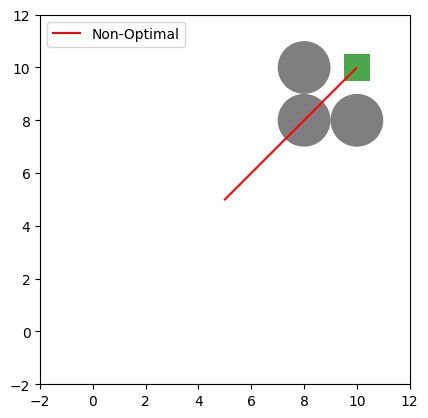

In [8]:
plot_1_traj(xs_non_optimal, obs_set, target_high, label='Non-Optimal', linemap = 'r')

In [9]:
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_des[:nr], w_des[nr:], timeStep))
print('Bad Trajectory Cost:      ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || other Trajectory, same cost:   ', cost_set.traj_cost(xs_optimal, us_optimal, w_bad[:nr], w_bad[nr:], timeStep))

Desired Trajectory Cost:   0.8368197222980587  || other Trajectory, same cost:    3.3916994987999383
Bad Trajectory Cost:       0.3939303420001925  || other Trajectory, same cost:    1.100495760303379


In [10]:
###### IRL #######

In [11]:
# generating bad trajectories
num_bad = 10
scales = 5.0
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.stack(xs_non_optimal.tolist()).copy())
us_non_optimal_set.append(np.stack(us_non_optimal.tolist()).copy())
for _ in range(num_bad):
    # # Get one non-optimal sample from non-optimal demo
    Us = us_non_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))
    # # Get one non-optimal sample from optimal demo
    Us = us_optimal.copy()+np.random.normal(0,scales,np.stack(us_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(np.stack(problem.rollout([Us[i] for i in range(T)])))

In [12]:
opt_cost = np.exp(-cost_set.traj_cost(xs_optimal,us_optimal,w_des[:nr], w_des[nr:], timeStep))
print(opt_cost)
for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    print('Modified: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep))/opt_cost, 
         'Original: ', np.exp(-cost_set.traj_cost(X,U,w_bad[:nr], w_bad[nr:], timeStep)))

0.43308566829267114
Modified:  1.557200067806255 Original:  0.6744010320312648
Modified:  3.759722943209652e-05 Original:  1.6282821234552405e-05
Modified:  0.0007260464135272695 Original:  0.0003144402962139546
Modified:  0.0022225648343818147 Original:  0.0009625609766220381
Modified:  0.0231989442175508 Original:  0.010047130260142386
Modified:  0.012555640416965028 Original:  0.005437667920823772
Modified:  0.31248410168388535 Original:  0.13533238600860048
Modified:  8.754265098410112e-14 Original:  3.79134675055615e-14
Modified:  0.2051908386423414 Original:  0.08886521148095207
Modified:  0.4341813296034306 Original:  0.18803771129150226
Modified:  0.1339483983945348 Original:  0.05801113163543006
Modified:  0.03548348833369521 Original:  0.01536739025835359
Modified:  4.43601941228382e-07 Original:  1.9211764317282003e-07
Modified:  0.12034062981577948 Original:  0.052117802086527804
Modified:  2.9899123379740525e-08 Original:  1.2948881830279953e-08
Modified:  0.00011655864608

In [13]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds

def fcn_w(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    # x /= np.linalg.norm(x)
    nr = cost_set.nr
    output = 0
    num = np.nextafter(0,1)
    den = np.nextafter(0,1)
    num += np.exp(-cost_set.traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_nSamples(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda = 0.001):
    nr = cost_set.nr
    num_samples = samples # Have these number of samples per trajectory equidistantly starting from the beginning
    output = 0
    for i in np.int32(np.linspace(0, len(xs_optimal), num=num_samples+1))[:-1]:
        num = np.nextafter(0,1)
        den = np.nextafter(0,1)
        X_opt = xs_optimal[i:].copy(); U_opt = us_optimal[i:].copy()
        num += np.exp(-cost_set.traj_cost(X_opt, U_opt, x[:nr], x[nr:], dt))
        den += num
        for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
            X_nopt = Xs[i:].copy(); U_nopt = Us[i:].copy()
            den += np.max([np.nextafter(0,1), np.exp(-cost_set.traj_cost(X_nopt, U_nopt, x[:nr], x[nr:], dt))])
        output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_cum(x, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    return True

# def fcn_w_nD(x, cost_set, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
#     # x /= np.linalg.norm(x)
#     nr = cost_set.nr
#     output = 0
#     for Xs_opt, Us_opt in zip(xs_optimal_set, us_optimal_set):
#         num = np.nextafter(0,1)
#         den = np.nextafter(0,1)
#         num += np.exp(-cost_set.traj_cost(Xs_opt, Us_opt, x[:nr], x[nr:], dt))
#         den += num
#         for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
#             den += np.exp(-cost_set.traj_cost(Xs, Us, x[:nr], x[nr:], dt))
#         output -= np.log(num/den)
    
#     output += Lambda*np.linalg.norm(x)
#     return output



In [51]:
dt = timeStep
Lambda = 0.0
lb = 0.0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': 1,'ftol': 1e-15 ,'gtol' : 1e-15}
tol = 1e-15
samples = 1
# w0 = w_bad
w0 = np.zeros_like(w_bad)
# w0 = w_des
# w0 = 10*np.ones_like(w_bad)

# 1 Optimal Demo
args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda)
res = minimize(fcn_w, 
               w0, 
               args, 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)
print(res)

# 1 Optimal Demo, Multiple Samples
# args=(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, samples, Lambda)
# res = minimize(fcn_w_nSamples, 
#                w0, 
#                args, 
#                bounds=bnds, 
#                method='L-BFGS-B', 
#                tol = tol,
#                options=options)
# print(res)


# WIRL = []
# for i in range(1,len(xs_non_optimal_set)):
#     xs_no_subset = xs_non_optimal_set[:i]
#     us_no_subset = us_non_optimal_set[:i]
#     res = minimize(fcn_w, 
#                    w0, 
#                    args=(cost_set, xs_optimal, us_optimal, xs_no_subset, us_no_subset, dt, Lambda), 
#                    bounds=bnds, 
#                    method='L-BFGS-B', 
#                    tol = tol,
#                    options=options)
#     WIRL.append(res.x)
#     print(res)

w_irl = res.x

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0        12 variables are exactly at the bounds

At iterate    0    f=  3.09104D+00    |proj g|=  1.05929D+01

At iterate    1    f=  2.80012D+00    |proj g|=  3.81149D+00

At iterate    2    f=  2.49853D+00    |proj g|=  3.87296D+00

At iterate    3    f=  2.16406D+00    |proj g|=  2.84347D+00

At iterate    4    f=  1.64271D+00    |proj g|=  1.45469D+00

At iterate    5    f=  1.58143D+00    |proj g|=  1.33746D+00

At iterate    6    f=  1.15009D+00    |proj g|=  1.00370D+00

At iterate    7    f=  7.01948D-01    |proj g|=  6.28522D-01

At iterate    8    f=  4.10611D-01    |proj g|=  3.85056D-01

At iterate    9    f=  2.16283D-01    |proj g|=  2.06636D-01

At iterate   10    f=  1.09343D-01    |proj g|=  5.79556D-01

At iterate   11    f=  5.45811D-02    |proj g|=  5.88390D-01

At iterate   12    f=  2.73315D-02    |proj g|=  4.44761D-01

At iterate   13    f=  1.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [52]:
# w_irl /= np.max(w_irl)
for i, cost in enumerate(cost_set.costs):
    print(cost.name, ':')
    print('Running || ', 'Desired: ', w_des[:nr][i], 'IRL: ', w_irl[:nr][i])
    print('Terminal || ', 'Desired: ', w_des[nr:][i], 'IRL: ', w_irl[nr:][i])
    print('')

trans_high :
Running ||  Desired:  0.005 IRL:  0.0
Terminal ||  Desired:  1.0 IRL:  22.152189916313816

XReg :
Running ||  Desired:  0.0005 IRL:  0.0
Terminal ||  Desired:  0.0005 IRL:  0.0

UReg :
Running ||  Desired:  0.0005 IRL:  0.035774654263402976
Terminal ||  Desired:  0.0005 IRL:  0.0

Obs1 :
Running ||  Desired:  0.5 IRL:  3.6393841886559555
Terminal ||  Desired:  0.5 IRL:  3.925392406855836

Obs2 :
Running ||  Desired:  0.5 IRL:  3.0870504388004023
Terminal ||  Desired:  0.5 IRL:  1.5466935501016816

Obs3 :
Running ||  Desired:  0.5 IRL:  6.791039615611117
Terminal ||  Desired:  0.5 IRL:  1.8586119943102775



In [53]:
# w_irl = w_irl/np.max(w_irl)

In [54]:
print('Desired Trajectory Cost: ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_irl[:nr], w_irl[nr:], timeStep))
print('Bad Trajectory Cost:     ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL Weight:  ', cost_set.traj_cost(xs_non_optimal, us_non_optimal, w_irl[:nr], w_irl[nr:], timeStep))

Desired Trajectory Cost:  0.8368197222980587  || with IRL Weight:   11.830189091179733
Bad Trajectory Cost:      0.3939303420001925  || with IRL Weight:   31.65781383756261


In [55]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL Fcn:        ', fcn_w(w_irl, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w(w_bad, cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     0.4892076702530379
IRL Fcn:         6.22605857698318e-09
Bad Fcn:         1.5497883899327523


In [65]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr]
w_term = w_irl[nr:]
PM_DAM_running = DifferentialActionModelPointMass(cost_set, w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(cost_set, w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = start_point
x0 = np.array([9.5, 11.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 1e-5
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]
# xs_init = [xs_optimal[i] for i in range(T+1)]
# us_init = [us_optimal[i] for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 500)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  2.04846e+01  2.04846e+01  6.64484e+00  1.0000  0.00000e+00  2.22240e+01
   2  7.77191e+00  7.77191e+00  7.26832e+00  1.0000  4.61853e-14  7.05560e+00
   3  4.83833e+00  4.83833e+00  6.25078e+00  1.0000  1.36755e-08  4.97144e-01
   4  4.75340e+00  4.75340e+00  4.37768e+00  1.0000  1.16892e-08  1.64174e-01
   5  4.59095e+00  4.59095e+00  1.80522e+00  1.0000  7.71685e-09  6.13321e-02
   6  4.45227e+00  4.45227e+00  5.41479e-01  1.0000  3.47029e-09  7.88953e-03
   7  4.44760e+00  4.44760e+00  2.94225e-02  1.0000  1.16990e-09  6.69574e-04
   8  4.44758e+00  4.44758e+00  4.85356e-04  1.0000  5.58678e-11  1.28833e-05
 END  4.44758e+00  4.44758e+00  1.22386e-07   ----   9.68758e-13  4.07441e-09


In [66]:
print('IRL Trajectory Cost:  ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('with Desired Weight:  ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep)) 
print('with Bad Weight:      ', cost_set.traj_cost(xs_output, us_output, w_bad[:nr], w_bad[nr:], timeStep))

IRL Trajectory Cost:   4.447581796349857
with Desired Weight:   0.6802713018196591
with Bad Weight:       0.19407738335716718


In [67]:
print('IRL Trajectory Cost:      ', cost_set.traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], timeStep))
print('Desired Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory Cost:       4.447581796349857
Desired Trajectory Cost:   0.8368197222980587


In [68]:
print('IRL Trajectory with Desired Cost: ', cost_set.traj_cost(xs_output, us_output, w_des[:nr], w_des[nr:], timeStep))
print('Initial Optimal Trajectory Cost:  ', cost_set.traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep))

IRL Trajectory with Desired Cost:  0.6802713018196591
Initial Optimal Trajectory Cost:   0.8368197222980587


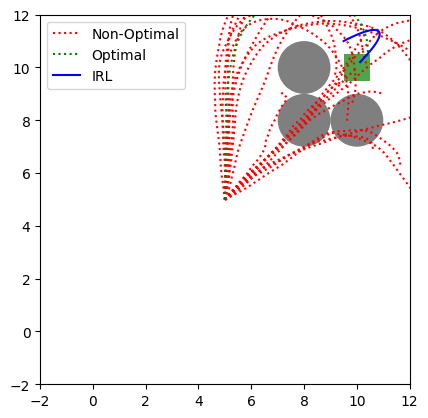

In [69]:
plot_results(xs_optimal, xs_non_optimal_set, xs_output, obs_set, target_high)

In [70]:
P_irl = distributions(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, w_irl[:nr], w_irl[nr:], dt)
P_des = distributions(cost_set, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, w_des[:nr], w_des[nr:], dt)   

In [71]:
P_irl/np.max(P_irl)

array([1.00000000e+000, 2.44890526e-009, 6.85076184e-104, 3.58908801e-068,
       4.76236460e-071, 7.33484942e-034, 1.09390366e-048, 3.77715331e-009,
       1.79828691e-291, 8.53338767e-017, 4.25394436e-026, 5.33077846e-025,
       3.82711023e-047, 4.57765295e-138, 2.63481528e-029, 7.71706353e-162,
       3.87490546e-099, 3.58913265e-280, 1.82269203e-261, 2.82035887e-142,
       2.43203238e-132, 2.21381931e-050])

In [72]:
P_des/np.max(P_des)

array([1.00000000e+00, 7.77015731e-02, 1.18168707e-05, 8.59246876e-04,
       1.09666179e-04, 3.87313313e-02, 3.60648842e-03, 4.03000315e-01,
       3.91775258e-14, 5.72473323e-02, 5.90265588e-03, 1.97578299e-02,
       1.62063593e-03, 5.95012439e-07, 2.16702817e-02, 5.63155810e-08,
       9.01814334e-06, 1.93728703e-13, 7.94225813e-13, 4.25955058e-07,
       4.17197453e-07, 7.93713972e-04])

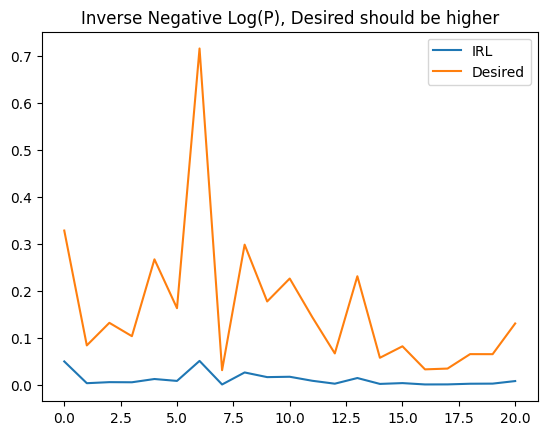

In [73]:
plt.plot(-1/np.log(P_irl[1:]),label='IRL')
plt.plot(-1/np.log(P_des[1:]),label='Desired')
plt.legend()
plt.title('Inverse Negative Log(P), Desired should be higher')
plt.show()